## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

This project aims to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [199]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data and store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [200]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [201]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [202]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [203]:
len(df[df['converted'] == 1]) / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [204]:
treatment_old_page = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
control_new_page = df[(df.group == 'control') & (df.landing_page == 'new_page')]
drop_rows = treatment_old_page.append(control_new_page).index
drop_rows.shape[0]

3893

f. Do any of the rows have missing values?

In [205]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

These rows should be removed as only data we can trust to be accurate should be kept.

a. Create a new dataset removing the non-accurate data. Store new dataframe in **df2**.

In [206]:
df2 = df.drop(drop_rows)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [207]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [208]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [209]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [210]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [211]:
df2.drop(df2[df2.user_id.duplicated()]['user_id'].index, inplace=True)

`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [212]:
p_convert = df2['converted'].mean()
p_convert

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [213]:
p_convert_control = df2[df2.group == 'control']['converted'].mean()
p_convert_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [214]:
p_convert_treatment = df2[df2.group == 'treatment']['converted'].mean()
p_convert_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [215]:
p_new_page = (df2['landing_page'] == 'new_page').mean()
p_new_page

0.5000619442226688

#### Results and Discussion

Part **d** indicates the probability of landing on either of the two pages is equivalent, hence effects of uneven weightings between pages have been removed.

Overall, there is insufficient evidence to conclude that the new treatment page leads to more conversions. This is proven by the lower conversion rate when landing on the new treatment page as compared to the old page (12.04% vs 11.88% respectively).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  Hypothesis is stated in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<h1><center> $H_0$: $p_{new}$ - $p_{old}$ $\leq$ 0 </center></h1>

<h1><center> $H_1$: $p_{new}$ - $p_{old}$ > 0 </center></h1>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [216]:
# Assumption is p_new = p_old as defined above.
# Convert rate is equal to the overall convert rate calculated previously
p_convert

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [217]:
# Assumption is p_new = p_old as defined above.
# Convert rate is equal to the overall convert rate calculated previously
p_convert

0.11959708724499628

c. What is $n_{new}$?

In [218]:
n_new = (df2['landing_page'] == 'new_page').value_counts()[1]
print(n_new)

145310


d. What is $n_{old}$?

In [219]:
n_old = (df2['landing_page'] == 'new_page').value_counts()[0]
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [220]:
new_page_converted = np.random.choice([0, 1], n_new, [(1-p_convert), p_convert])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [221]:
old_page_converted = np.random.choice([0 ,1], n_old, [(1-p_convert), p_convert])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [222]:
simulated_diff = new_page_converted.mean() - old_page_converted.mean()
actual_diff = p_convert_treatment - p_convert_control
print('Simulated Difference: {}\nActual Difference: {}'.format(simulated_diff, actual_diff))

Simulated Difference: 0.003448051942164354
Actual Difference: -0.0015782389853555567


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [223]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], n_new, [(1-p_convert), p_convert])
    old_page_converted = np.random.choice([0 ,1], n_old, [(1-p_convert), p_convert])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

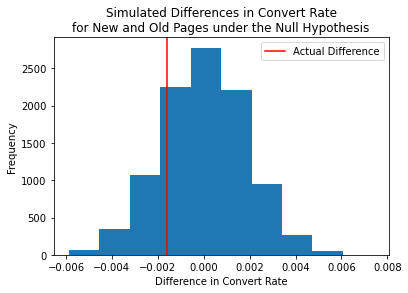

In [224]:
plt.hist(p_diffs)
plt.axvline(x=actual_diff, color='r', label="Actual Difference")
plt.xlabel('Difference in Convert Rate')
plt.ylabel('Frequency')
plt.title('Simulated Differences in Convert Rate\nfor New and Old Pages under the Null Hypothesis')
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [225]:
(p_diffs > actual_diff).mean()

0.8087

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### Results

What was computed in **j** was the proportion of the simulated differences in convert rates, **p_diffs**, which are greater than the actual difference observed in the dataset **ab_data.csv**.

Scientifically, this value is referred to as the p-value. Since the p-value is much larger than the threshold, defined as $\alpha = 0.05$, there is insufficient evidence to reject the null hypothesis. Hence, we conclude that there is insufficient evidence to indicate any difference between the new and old pages convert rates.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Below, calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [226]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [227]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### Results

The z-score and p-value computed indicate there is insufficient evidence to reject the null hypothesis. The p-value of **0.905** is again much higher than the allowable Type I error threshold of $\alpha = 0.05$.

This conclusion is in agreement with the bootstrapping hypothesis testing results calculated in **j** and discussed in **k**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression** - Dependent variable is binary (conversion vs no conversion).

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [228]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.drop('old_page', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [229]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [230]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        10:52:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

#### Result

The p-value associated with **ab_page** is **0.190**. 

The difference in p-values arises from fundamentally different null and alternative hypotheses in Parts II and III.

**Part II** $\rightarrow$ Alternative Hypothesis: $H_1$: $p_{new} - p_{old} > 0$. This is a one-tailed test.

**Part III** $\rightarrow$ Alternative Hypothesis: $H_1$: $p_{new} \neq p_{old}$. This is a two-tailed test.

Nonetheless, in both cases p-value > $\alpha$. Consequently, there is insufficient evidence to reject the null hypothesis for either Part.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Advantages: Including additional factors allows for identification of alternative conditions influencing the conversion rate, both positively and negatively. This gives a broader picture of which factors are statistically significant in improving conversion rate.

Disadvantages: Makes the model more complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [231]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner').reset_index()
print(df_new.country.unique())
df_new.head()

['UK' 'US' 'CA']


,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [242]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.drop('CA', axis=1, inplace=True)
df_new['intercept'] = 1
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [246]:
### Fit New Model
lm_new = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results_new = lm_new.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [247]:
### Summarize Results
results_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        10:57:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

#### Results

As well as testing if the conversion rate changes for different pages, an effect based on which country a user lives was also added.

The p-values for the different countries are still greater than the threshold $\alpha=0.05$. This again indicates there is still insufficient evidence to reject the null hypothesis. We can therefore conclude that there is no significant contribution from the user country location to the difference in conversion rate between different pages.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Investigate the interaction between landing page and UK location, as well as that between landing page and US location, to identify if there are significant effects on conversion.

In [250]:
### Define Interaction Columns
df_new['UK_ab_page'] = df_new['ab_page'] * df_new['UK']
df_new['US_ab_page'] = df_new['ab_page'] * df_new['US']
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [252]:
### Fit Linear Model And Obtain the Results
lm_interaction = sm.Logit(df_new['converted'],df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results_interaction = lm_interaction.fit()
results_interaction.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        11:15:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

#### Results Interaction

Once again, all interaction parameters show p-values higher than the threshold $\alpha=0.05$. Thus, we again have insufficient evidence to reject the null hypothesis, hence indicating we fail to identify an interaction between landing page and country which predicts user conversion. The influence of the landing page in any country is equivalent to that in any other country.

<a id='conclusions'></a>
### Conclusions

Overall, there is insufficient evidence to state that the new landing page improves the conversion rate as compared to the old landing page.

Probability figures indicate this via the lower conversion rate when landing on the new treatment page as compared to the old page (12.04% vs 11.88% respectively).

A/B testing indicates this via an obtained p-value which is much larger than the threshold, defined as $\alpha = 0.05$, indicating there is insufficient evidence to reject the null hypothesis, meaning there is insufficient evidence to indicate any difference between the conversion rates of the new and old landing pages.

Regression testing indicates this via p-values being consistently higher that the threshold $\alpha=0.05$. This is true for the landing page, country from which the landing page is accessed, and interaction between country and landing page, indicating there is insufficent evidence to reject the null hypothesis, and so we conclude user conversion is not improved by the new landing page.

Additionally, we fail to identify any relationship between the country in which the landing page is accessed and the conversion rate, indicating no evidence that country influences conversion.

Finally, the large sample size and ample evidence to accept the null hypothesis as true suggests no additional testing on the new landing page is required, as it does not prove beneficial in terms of increasing conversion rate.